In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
%matplotlib inline

In [2]:
words = open('../../data/names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {char:i for i,char in enumerate(chars)}
stoi['.'] = 0 
itos = {i:char for char,i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
27


In [4]:
def build_dataset(words): 
    block_size = 3
    X, Y = [], []
    for w in words: 
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
        

In [5]:
block_size = 3

In [6]:
import random 
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train , Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# 2 dimensional embedding
C = torch.randn((27, 2))

In [8]:
emb = C[X_train] # Embedding lookup
emb.shape

torch.Size([182625, 3, 2])

In [9]:
# Weights and biases
W1 = torch.randn((2*block_size, 128))
b1 = torch.randn((128))

In [10]:
h = torch.tanh(emb.view(-1, 2*block_size) @ W1 + b1) # Hidden layer
h.shape

torch.Size([182625, 128])

In [11]:
W2 = torch.randn((128, 27))
b2 = torch.randn((27))

logits = h @ W2 + b2 # Logits
logits.shape

torch.Size([182625, 27])

In [12]:
counts = logits.exp() # Log counts 
probs = counts / counts.sum(-1, keepdim=True) # Probabilities

## Putting all toegehter

In [53]:
# Let's put everything together
embedding_dim = 3
hidden_dim = 300

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_dim), generator=g) 
W1 = torch.randn((embedding_dim*block_size, hidden_dim), generator=g) * 0.2 # Kaiming initialization would be (5/3) * ((embedding_dim*block_size) ** 0.5), Kaiming Initialization performs worse here thats why I'm  using 0.2
b1 = torch.randn((hidden_dim), generator=g) * 0.01
W2 = torch.randn((hidden_dim, vocab_size), generator=g) * 0.01 # Initialize weights to small values
b2 = torch.randn(vocab_size, generator=g) * 0 # Initialize bias to zero

params = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad_()

11208


In [14]:
# --------------------------- Manual loss computation ---------------------------
#counts = logits.exp() # Log counts
#probs = counts / counts.sum(-1, keepdim=True) # Probabilities
#loss = -probs[torch.arange(32), Y].log().mean() # Negative log likelihood

# Would never do this in practice, just for illustration, not efficient for memory and for backpropagation
# F.cross entropy better numerical stability, high numbers in exp can lead to numerical instability (numerical overflow)
 # --------------------------- Manual loss computation ---------------------------

In [15]:
# Exponential learning rates 
lre= torch.linspace(-3, 0, 10000)
lrs = 10 ** lre


In [54]:
lri = []
lossi = []
stepi = []

batch_size = 32

for i in range(30000):
    
    # minibatch contruction
    idx = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    
    Xb, Yb = X_train[idx], Y_train[idx]
    
    # Forward pass
    emb = C[Xb] # Embedding lookup
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Logits 
    loss = F.cross_entropy(logits, Yb) # Equivalent to the above with Pytorch function
    #print(loss.item())
    
    # Backward pass

    for p in params:
        p.grad = None
    loss.backward()
    # update 
    #lr = lrs[i]
    lr = 0.1 if i < 20000 else 0.01 # learning rate decay
    for p in params: 
        p.data += -lr * p.grad
    
    if i % 3000 == 0:
        print(f"Epoch {i}, Loss {loss.item()}")
    # track learning rate and loss
    #lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
print(loss.item())

Epoch 0, Loss 3.276824951171875
Epoch 3000, Loss 2.2878191471099854
Epoch 6000, Loss 2.2919557094573975
Epoch 9000, Loss 2.494574546813965
Epoch 12000, Loss 2.4609601497650146
Epoch 15000, Loss 2.1190104484558105
Epoch 18000, Loss 2.560443878173828
Epoch 21000, Loss 2.030219316482544
Epoch 24000, Loss 1.97328519821167
Epoch 27000, Loss 2.2088520526885986
1.8269526958465576


## Plots without Random Initalization 

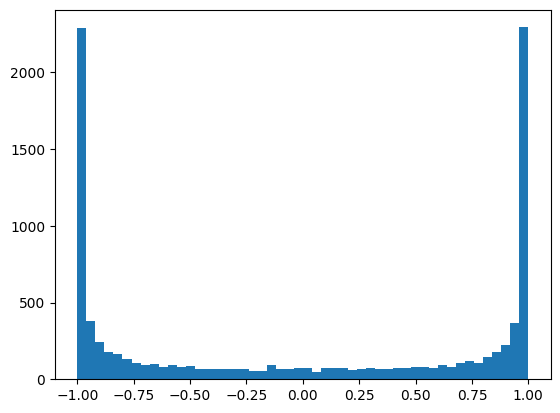

In [22]:
# Most hidden units are zero which is a problem for backpropagation
# 1 & -1 results in zero gradient in backpropagation
# The closer the value is to 1 or -1 the smaller the gradient will be because its in the flattes part of the tanh function
# this is often referred to as the vanishing gradient problem
plt.hist(h.detach().numpy().flatten(), bins=50);

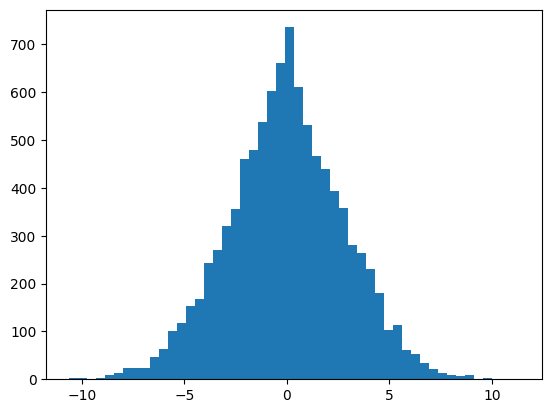

In [23]:
# If we look at the step before the activation function, we see 
plt.hist(hpreact.detach().numpy().flatten(), bins=50);

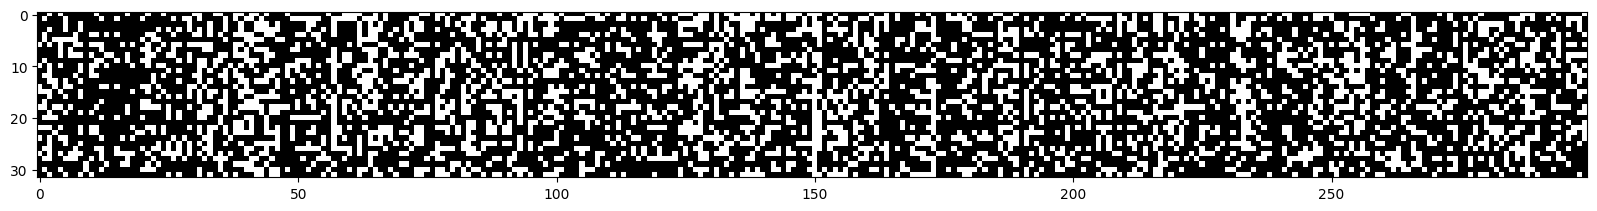

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')
# All white squares are zero, in all those cases the gradient will be zero or very close to zero
# A completely white column would be a dead neuron because it would never learn anything

## Plots with squashed Weights & Biases (W1 & B1)

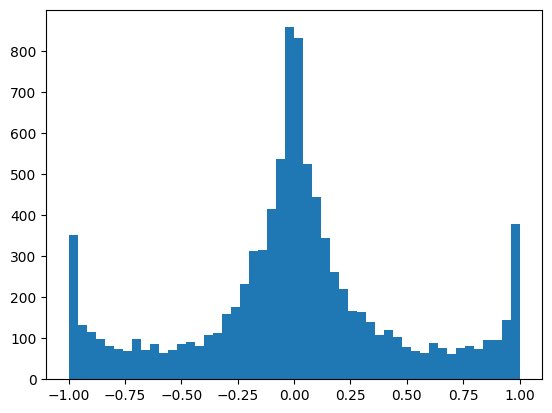

In [55]:
plt.hist(h.detach().numpy().flatten(), bins=50);

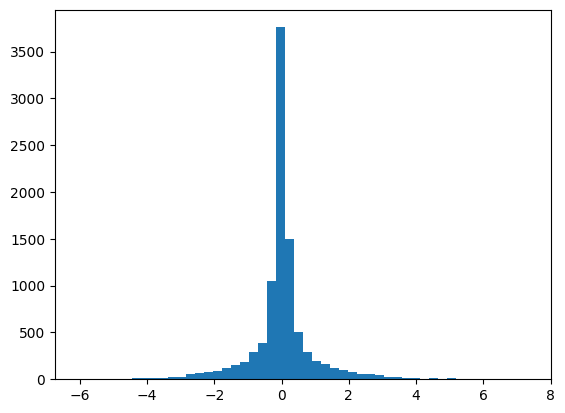

In [56]:
plt.hist(hpreact.detach().numpy().flatten(), bins=50);

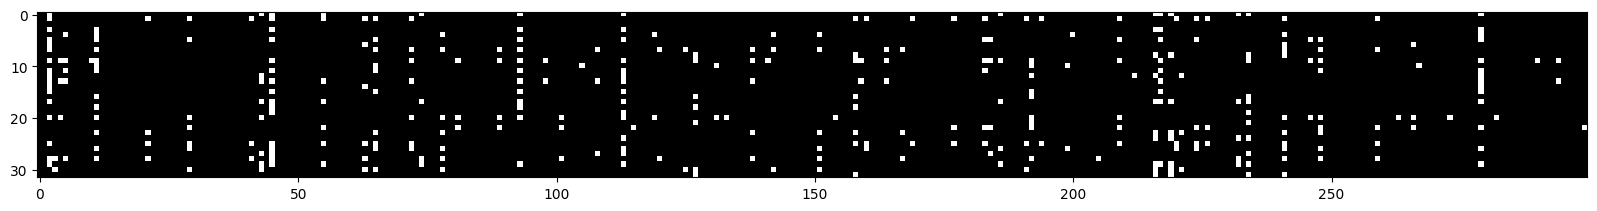

In [57]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

In [ ]:
# Normal probability distribution
# Log likelihood of any character in the Vocabulary is -log(1/27) = 3.2958 (Expected loss at initialization)
-torch.tensor(1/27).log()

tensor(3.2958)

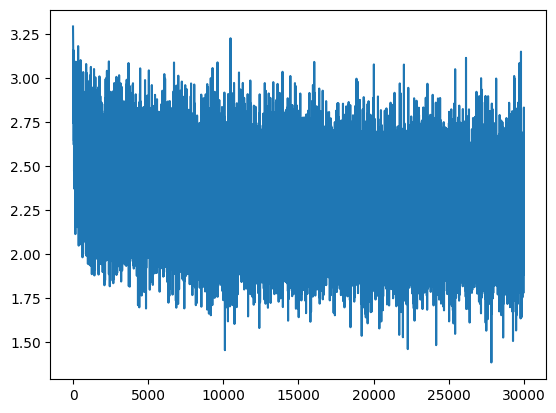

In [33]:
#plot 
plt.plot(stepi, lossi)

In [40]:
# Evaluation

@torch.no_grad() # Decorator to disable gradient tracking, similar to torch.no_grad() context manager

def split_loss(split): 
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate embeddings into N, block_size * embedding_dim
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
split_loss('train')
split_loss('val')

train loss: 2.229020357131958
val loss: 2.23012638092041


In [43]:
torch.randn(1000).mean()

tensor(0.0551)

## Visualize the Embeddings

Only works for 2 dimensional embeddings accurately

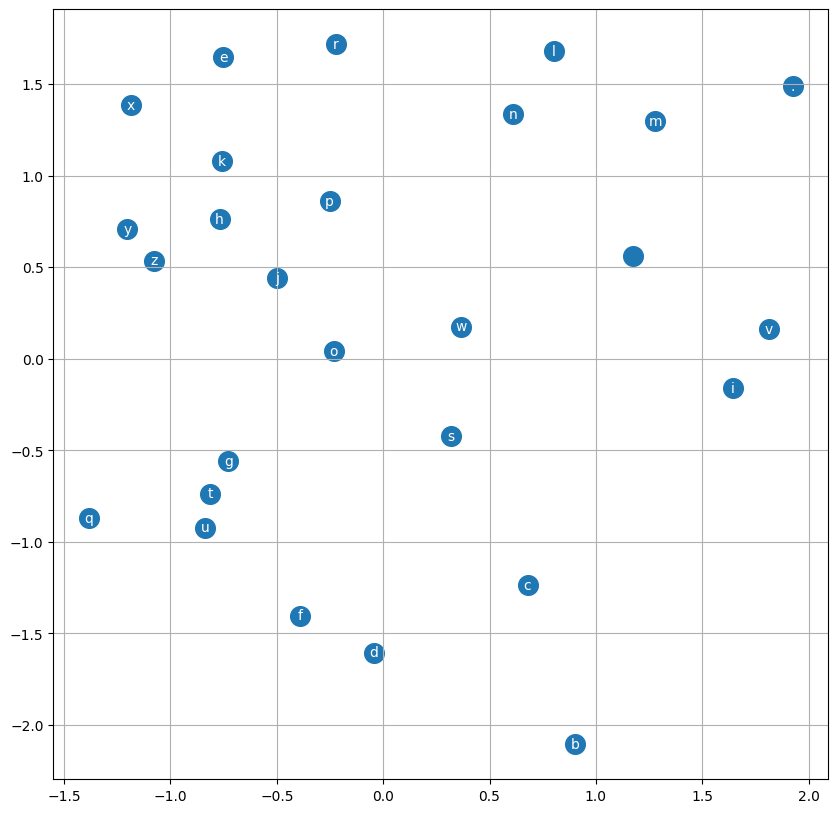

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200) 
for i in range(C.shape[0]):
    if i in itos:
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = 'center', va = 'center', color = 'white', fontsize = 10)
    
plt.grid('minor')
plt.show()

## Plot 3 Dimensional Embeddings Visualization

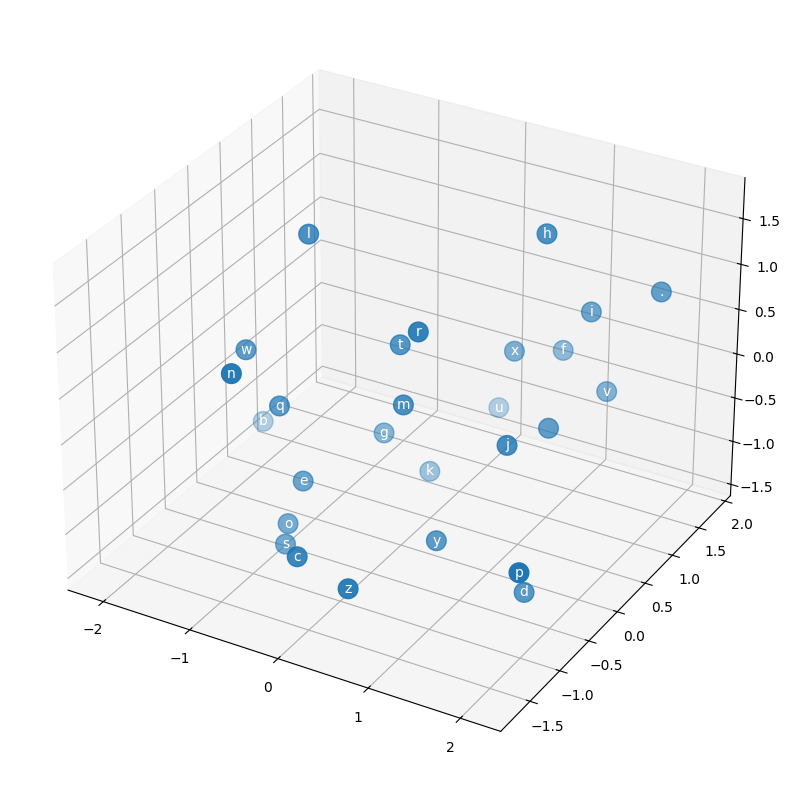

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(C[:, 0].data, C[:, 1].data, C[:, 2].data, s = 200)

for i in range(C.shape[0]):
    if i in itos:
        ax.text(C[i, 0].item(), C[i, 1].item(), C[i, 2].item(), itos[i], ha = 'center', va = 'center', color = 'white', fontsize = 10)

plt.show()

## Batch Normalization
Same code as above

In [78]:
embedding_dim = 3
hidden_dim = 300

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_dim), generator=g) 
W1 = torch.randn((embedding_dim*block_size, hidden_dim), generator=g) * 0.2 # Kaiming initialization would be (5/3) * ((embedding_dim*block_size) ** 0.5), Kaiming Initialization performs worse here thats why I'm  using 0.2
b1 = torch.randn((hidden_dim), generator=g) * 0.01
W2 = torch.randn((hidden_dim, vocab_size), generator=g) * 0.01 # Initialize weights to small values
b2 = torch.randn(vocab_size, generator=g) * 0 # Initialize bias to zero


bngain = torch.ones((1, hidden_dim)) # Batch normalization gain
bnbias = torch.zeros((1, hidden_dim)) # Batch normalization bias
bn_mean_running = torch.zeros((1, hidden_dim)) # Running mean
bn_std_running = torch.ones((1, hidden_dim)) # Running variance

params = [C, W1, b1, W2, b2, bnbias, bngain]
print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad_()

11808


In [87]:
lri = []
lossi = []
stepi = []

batch_size = 32

for i in range(30000):
    
    # minibatch contruction
    idx = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[idx], Y_train[idx]
    
    # Forward pass
    emb = C[Xb] # Embedding lookup
    embcat = emb.view(emb.shape[0], -1) # Concatenate embeddings into N, block_size * embedding_dim
    hpreact = embcat @ W1 + b1 # b1 here is usless because we are going to use batch normalization
    # -------- Batch Norm Layer --------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)    
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias
    
    with torch.no_grad():
        bn_mean_running = 0.9 * bn_mean_running + 0.001 * bnmeani
        bn_std_running = 0.9 * bn_std_running + 0.001 * bnstdi 
        
    # -------- Non Linearity --------
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # Logits 
    loss = F.cross_entropy(logits, Yb) # Equivalent to the above with Pytorch function
    #print(loss.item())
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    # update 
    #lr = lrs[i]
    lr = 0.1 if i < 20000 else 0.01 # learning rate decay
    for p in params: 
        p.data += -lr * p.grad
    
    if i % 3000 == 0:
        print(f"Epoch {i}, Loss {loss.item()}")
    # track learning rate and loss
    #lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
print(loss.item())

Epoch 0, Loss 2.87931752204895
Epoch 3000, Loss 2.0657544136047363
Epoch 6000, Loss 2.65303897857666
Epoch 9000, Loss 2.2088425159454346
Epoch 12000, Loss 2.3535890579223633
Epoch 15000, Loss 2.108231544494629
Epoch 18000, Loss 2.456542730331421
Epoch 21000, Loss 2.0172622203826904
Epoch 24000, Loss 2.09719181060791
Epoch 27000, Loss 1.9739716053009033
1.9504708051681519


In [89]:
@torch.no_grad() # Decorator to disable gradient tracking, similar to torch.no_grad() context manager

def split_loss(split): 
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # Concatenate embeddings into N, block_size * embedding_dim
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bn_mean_running) / bn_std_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
split_loss('train')
split_loss('val')

train loss: 3.5940005779266357
val loss: 3.6120896339416504


## Sample from the model 

In [65]:
g  = torch.Generator().manual_seed(42)

for _ in range(10): 
    
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs,num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join([itos[i] for i in out]))
        

zuphzpimw.
jjr.
pmycletn.
kh.
kzr.
juzwre.
dixd.
fber.
m.
pryj.
